### Estimación de tasa de prevalencia de corrupción en trámites por cada 100,000 habitantes

Este notebook contiene el código para estimar la tasa de prevalencia de corrupción en trámites por cada 100,000 habitantes utilizando datos de la Encuesta Nacional de Calidad e Impacto Gubernamental (ENCIG) 2023.

In [ ]:
rm(list=ls())

# Librerías ====
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse, srvyr)

Cargando paquete requerido: pacman



##### Descarga de archivos de la ENCIG

In [ ]:
#Directorio para guardar datos
dir.create("data", showWarnings = FALSE)

In [ ]:
url_encig_basica<-"https://www.inegi.org.mx/contenidos/programas/encig/"
segunda_parte<-"microdatos/encig"
years_encig<-c("2023")

In [5]:
# Descargar los archivos, descomprimirlos y renombrarlos
options(timeout=10000)
for (i in 1:length(years_encig)) {
  # Ajustar el sufijo de la URL y archivo según el año
  if (years_encig[i] %in% c("2017", "2019")) {
    fin <- "_base_datos_dbf.zip"
  } else {
    fin <- "_base_datos_csv.zip"
  }

  # Construir la URL y el nombre del archivo destino
  url <- paste0(url_encig_basica, years_encig[i], "/", segunda_parte, str_sub(years_encig[i], 3, 4), fin)
  print(url)
  destfile <- paste0("data/encig", str_sub(years_encig[i], 3, 4), fin)

  # Descargar el archivo
  download.file(url, destfile = destfile)

  # Descomprimir el archivo
  unzip(destfile, exdir = "data")
}

[1] "https://www.inegi.org.mx/contenidos/programas/encig/2017/microdatos/encig17_base_datos_dbf.zip"
[1] "https://www.inegi.org.mx/contenidos/programas/encig/2019/microdatos/encig19_base_datos_dbf.zip"
[1] "https://www.inegi.org.mx/contenidos/programas/encig/2021/microdatos/encig21_base_datos_csv.zip"
[1] "https://www.inegi.org.mx/contenidos/programas/encig/2023/microdatos/encig23_base_datos_csv.zip"


##### Lectura y procesamiento de datos

In [ ]:
#Variables llave para unir tablas
keys <- c("upm","v_sel","r_ele")

In [ ]:
# --- Lee datos---
#Se ocupan 3 tablas de la ENCIG
sec1 <- read_csv("data/encig2023_01_sec1_A_3_4_5_8_9_10.csv", show_col_types = FALSE) %>%
janitor::clean_names() %>%
  mutate(across(all_of(keys), as.character),
         fac_p18 = as.numeric(fac_p18),
         p8_3_1 = as.integer(p8_3_1),
         p8_3_2 = as.integer(p8_3_2),
         p8_3_3 = as.integer(p8_3_3))

sec6 <- read_csv("data/encig2023_03_sec_6.csv", show_col_types = FALSE) %>%
janitor::clean_names() %>%
  mutate(across(c(all_of(keys), "n_tra"), as.character),
         p6_1 = as.integer(p6_1),
         p6_3a = as.integer(p6_3a))

sec7 <- read_csv("data/encig2023_04_sec_7.csv", show_col_types = FALSE) %>%
    janitor::clean_names() %>%
  mutate(across(c(all_of(keys), "n_tra"), as.character),
         p7_3 = as.integer(p7_3))


New names:
• `` -> `...1`
New names:
• `` -> `...1`
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
New names:
• `` -> `...1`
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


##### Definición del numerador (Víctimas de corrupción en trámites)

In [ ]:
# --- C) Víctimas (numerador)
vict_c <- sec1 %>%
  transmute(across(all_of(keys)),
            est_dis, upm_dis, fac_p18,
            vict = as.integer(p8_3_1 == 1 | p8_3_2 == 1 | p8_3_3 == 1))

##### Definición del denominador (Población de 18 años y más que tuvo contacto con algún servidor público)

In [ ]:
# --- A) Policías/autoridades (VI), personal: N_TRA==20 & P6_1==1 & P6_3A>0
elig_A <- sec6 %>%
  filter(n_tra == "20", p6_1 == 1, coalesce(p6_3a,0) > 0) %>%
  distinct(across(all_of(keys))) %>%
  mutate(A = 1)

# --- B) Medio permitido (VII personal): P7_3 ∈ {1,3,6}
elig_B <- sec7 %>%
  filter(p7_3 %in% c(1,3,6)) %>%
  distinct(across(all_of(keys))) %>%
  mutate(B = 1)

# --- Base persona con puertas y pesos
base_persona <- vict_c %>%
  left_join(elig_A, by = keys) %>%
  left_join(elig_B, by = keys) %>%
  mutate(A = replace_na(A, 0),
         B = replace_na(B, 0),
         elig = pmax(A, B, vict)) %>%  # A ∪ B ∪ C
  # Renombramos columna PSU/STRATA “comunes” para pasar a srvyr como nombres simples
  mutate(psu = upm_dis, strata = est_dis)



##### Definición de diseño muestral y estimación de tasa de prevalencia de corrupción por cada 100000 habitantes

In [39]:
options(survey.lonely.psu = "adjust")  # manejo de estratos con 1 PSU
# ── Diseño muestral
dis_encig <- base_persona %>%
  as_survey_design(
    ids     = psu,
    strata  = strata,
    weights = fac_p18,
    nest    = TRUE
  )

In [ ]:
# ── Estimación nacional ──
res_nal <- dis_encig %>%
  summarize(
    num_vict  = survey_total(vict,  vartype = c("cv")),
    denom     = survey_total(elig,  vartype = c("cv")),
    tasa_prev = survey_ratio(vict, elig, vartype = c("cv"))
  ) %>%
    mutate(
        tasa_prev_100k      = 100000 * tasa_prev
    )

res_nal

num_vict,num_vict_cv,denom,denom_cv,tasa_prev,tasa_prev_cv,tasa_prev_100k
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5383732,0.02554774,38549281,0.008308292,0.1396584,0.02371224,13965.84


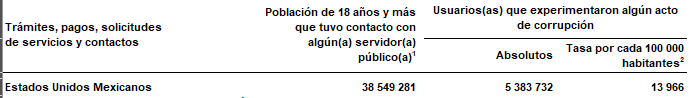